In [1]:
import numpy as np
import mdp
from CT_ucrl import ct_ucrl, extended_value_iteration
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Test of CT_MDP

In [19]:
eps = 0.2
alpha = 0.1
n_states = n_actions = 2
p = np.array([[[0, 1],[0, 1]],
     [[1, 0],[1, 0]]])
r = np.array([[5, 8], [-4, -12]])
holding_lambda = np.array([[3, 5], [2, 7]])
ct_mdp = mdp.CTMDP(2, 2, p, r, holding_lambda)
holding_time_record = {0: {0: [], 1:[]}, 1: {0: [], 1:[]}}
transit_record = {0: {0: np.array([0, 0]), 1:np.array([0, 0])}, 
                  1: {0: np.array([0, 0]), 1:np.array([0, 0])}}

In [22]:
print(ct_mdp.reset(0))
for i in range(50000):
    ac = np.random.randint(2)
    state = ct_mdp.state
    next_state, reward, holding_time = ct_mdp.step(ac)
    holding_time_record[state][ac].append(holding_time)
    transit_record[state][ac][next_state] += 1

0


In [23]:
for state in [0, 1]:
    for action in [0, 1]:
        print(state, action, 1/np.mean(holding_time_record[state][action]))
        print(transit_record[state][action]/np.sum(transit_record[state][action]))

0 0 2.9742060221650157
[0. 1.]
0 1 4.997715599364318
[0. 1.]
1 0 2.0086605468602277
[1. 0.]
1 1 6.999387074147967
[1. 0.]


# Test of CT_UCRL

In [40]:
eps = 0.1
alpha = 0.1
n_states = n_actions = 2
p = np.array([[[0, 1],[0, 1]],
     [[1, 0],[1, 0]]])
r = np.array([[5, 8], [-4, -12]])
holding_lambda = np.array([[3, 5], [2, 7]])

## Optimal Value Function

In [41]:
state_val, best_ac, best_mdp = extended_value_iteration(2, 2, np.array(r), np.array(p), 
                                                   np.zeros(np.shape(p)[:2]), 
                                                   1 / np.array(holding_lambda), 
                                                   np.zeros(np.shape(holding_lambda)), 
                                                   2, 7, 0.01)
rho_star = ((p[0][1] * state_val).sum() - state_val[0] + r[0, 1]) * holding_lambda[0, 1]
rho_star

5.714285714285712

## CT-UCRL

In [95]:
opt_tr = {}
num_dec_epoch = 1000000
num_sim = 20
opt_regret = {}
for sim in range(num_sim):
    print(sim, end='\r')
    opt_tr[sim] = []
    opt_regret[sim] = []
    ct_mdp = mdp.CTMDP(n_states, n_actions, p, r, holding_lambda)

    transitions = ct_ucrl(ct_mdp, np.max(holding_lambda), np.min(holding_lambda), 
                        r, 0.05, 0)
    sum_reward = 0

    for _ in range(num_dec_epoch):
        (t, st, ac, next_st, holding_time, reward) = transitions.__next__()
        opt_tr[sim].append((t, st, ac, next_st, holding_time, reward))
        sum_reward += reward
        opt_regret[sim].append(rho_star * ct_mdp.timer - sum_reward)

In [96]:
np_opt_regret = np.array([opt_regret[sim] for sim in range(num_sim)])
np_opt_regret

array([[-7.73313815e+00,  3.90618621e+00, -1.48694023e+00, ...,
         6.13834070e+02,  6.06671398e+02,  6.11053105e+02],
       [-5.92182735e+00, -8.42264945e-01, -8.38219112e+00, ...,
         3.49821772e+03,  3.49053422e+03,  3.49679735e+03],
       [-7.24637266e+00, -7.40738798e-01, -7.01810147e+00, ...,
         5.92511691e+03,  5.91791696e+03,  5.93122368e+03],
       ...,
       [-6.86702078e+00, -2.72152192e+00, -1.03970882e+01, ...,
         5.13973673e+03,  5.13199165e+03,  5.13611472e+03],
       [-6.84248946e+00, -2.66310650e+00, -1.04091709e+01, ...,
         6.62845130e+03,  6.62072401e+03,  6.62609210e+03],
       [-7.46651572e+00, -2.94575465e+00, -6.47165404e+00, ...,
         5.24924421e+03,  5.24204319e+03,  5.24638855e+03]])

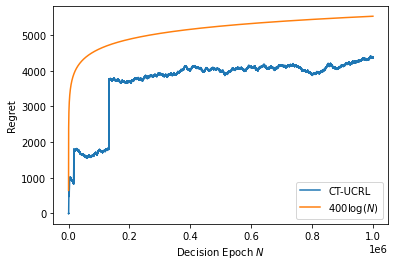

In [104]:
log_factor = 400
label_gap = 5
xlabel = [k * label_gap for k in range(1, num_dec_epoch // label_gap + 1)]
plt.plot(xlabel, np_opt_regret.mean(axis=0)[::label_gap], 
         label = 'CT-UCRL')
plt.plot(xlabel, log_factor * np.log(xlabel), 
         label=r'${}\log(N)$'.format(log_factor))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend()
plt.xlabel(r'Decision Epoch $N$')
plt.ylabel('Regret')
# plt.savefig('../../fig/CT-UCRL/EX1/average_path1', bbox_inches='tight', dpi=300)

Text(0, 0.5, 'Regret')

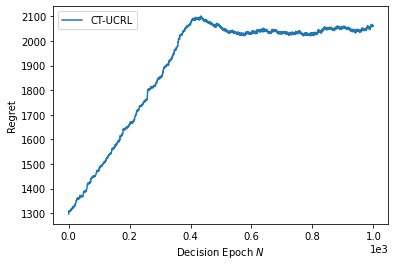

In [93]:
log_factor = 500
label_gap = 1
plt.plot(np_tr[17000:18000, 1] * rho_star - opt_cumsum_r[17000:18000], 
         label = 'CT-UCRL')
# plt.plot([k * 10000 for k in range(100)], log_factor * np.log(np_tr[:20000:10000, 0]), 
#          label=r'${}\log(N)$'.format(log_factor))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend()
plt.xlabel(r'Decision Epoch $N$')
plt.ylabel('Regret')

# Sub-optimal Policy

In [50]:
ct_mdp = mdp.CTMDP(n_states, n_actions, p, r, holding_lambda)
st = ct_mdp.reset(0)
sub_policy = np.array([0, 0])
sub_tr = []
for n in range(num_dec_epoch):
    next_st, reward, holding_time = ct_mdp.step(ac)
    # print('step', t, st, ac, next_st, reward)
    # Update statistics

    st = next_st
    ac = sub_policy[st]
    sub_tr.append((n, ct_mdp.timer, st, ac, next_st, reward))

In [51]:
np_sub_tr = np.array(sub_tr)
sub_rho = np_sub_tr[:, -1].sum() / ct_mdp.timer
sub_rho
sub_gap = rho_star - sub_rho
sub_gap

4.513250105694224

In [52]:
bound_const = 34**2 * holding_lambda.max() * 4 * 2 
print(bound_const)
bound_const += 2 * 73**2 * (holding_lambda.max() / holding_lambda.min())**2 * 2 * 2
print(bound_const)
bound_const += 24 * 2 * 2 / (holding_lambda.min()**2)
print(bound_const) 
bound_const *= 3
print(bound_const)

64736
586978.0
587002.0
1761006.0


In [78]:
2 * 73**2 * (holding_lambda.max() / holding_lambda.min())**2 * 2 * 2

10658